In [6]:
import trimesh
import numpy as np
import scipy.sparse as sparse
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import igl

# Geodesics In Heat

nb: steps are explained in the report

In [7]:
def add_Noise(mesh, std):
    #taken from geometry coursework 1
    points = mesh.vertices

    #Ensure the noise makes sense for the size of the mesh
    diff_x = np.max(points[:,0])-np.min(points[:,0])
    diff_y = np.max(points[:,1])-np.min(points[:,1])
    diff_z = np.max(points[:,2])-np.min(points[:,2])

    std_x = std * diff_x
    std_y = std * diff_y
    std_z = std * diff_z

    noisy_points = np.zeros_like(points)
    noisy_points[:,0] = points[:,0] + np.random.normal(0, std_x, points[:,0].shape)
    noisy_points[:,1] = points[:,1] + np.random.normal(0, std_y, points[:,1].shape)
    noisy_points[:,2] = points[:,2] + np.random.normal(0, std_z, points[:,2].shape)

    mesh.vertices = noisy_points
    return mesh

### Step 1: Discrete Heat Flow

In [8]:
#Choose source vertice to calculate the geodesic distance to the other points
source = 500 #1000, 2000 other good options

In [9]:
vertices, faces = igl.read_triangle_mesh('bunny.obj') 

# To use the uniform Laplace-Beltrami for the method
# # Mesh in (v, f)
# a = igl.adjacency_matrix(faces)
# # Sum each row
# a_sum = np.sum(a, axis=1)
# # Convert row sums into diagonal of sparse matrix
# a_diag = sparse.diags(np.array(a_sum).flatten())
# # Build uniform laplacian
# C = a - a_diag
# M = sparse.eye(vertices.shape[0])

# To use the cotangent discretization Laplace-Beltrami for the method
C = igl.cotmatrix(vertices, faces)
M = igl.massmatrix(vertices, faces, igl.MASSMATRIX_TYPE_VORONOI)


In [10]:
#load mesh in trimesh as well for vertex colouring
mesh = trimesh.load_mesh('bunny.obj') 

#calculate average length of an edge in the mesh
h = np.sum(mesh.edges_unique_length)/mesh.edges_unique_length.shape[0]

#time step that can be changed to change how much the heat diffuses
#greater t gives a smoother approximation
t = h 

A = M - (t * C)
# b = chosen_eigenvector[:,np.newaxis] #set eigenvector to source points
b = np.zeros(C.shape[0])[:,np.newaxis]
b[source] = 1 #set singular source point

u, info = sparse.linalg.cg(A, b) 

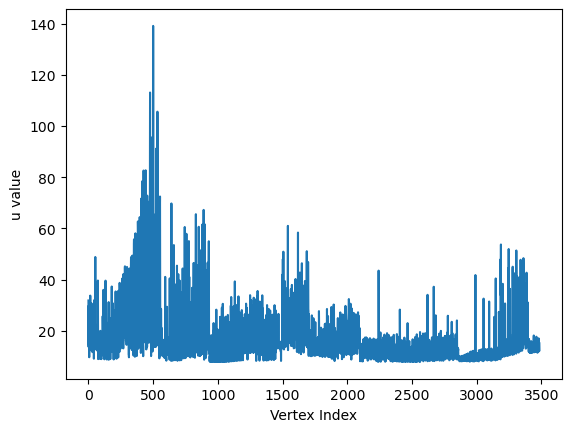

In [11]:
plt.plot(u)
plt.xlabel('Vertex Index')
plt.ylabel('u value')
plt.show()

### Step 2: Normalized vector field


In [12]:
areas = igl.doublearea(vertices,faces)
normals = igl.per_face_normals(vertices,faces, igl.per_vertex_normals(vertices,faces))

X = []

for i,f in enumerate(faces):
    face_vertices = [vertices[f[0]], vertices[f[1]], vertices[f[2]]]

    face_normal = normals[i]
    face_area = areas[i]

    e0 = face_vertices[2] - face_vertices[1]
    e1 = face_vertices[0] - face_vertices[2]
    e2 = face_vertices[1] - face_vertices[0]

    u0 = u[f[0]]
    u1 = u[f[1]]
    u2 = u[f[2]]

    gradu = 0
    gradu += u0 * np.cross(face_normal, e0)
    gradu += u1 * np.cross(face_normal, e1)
    gradu += u2 * np.cross(face_normal, e2)
    gradu /= face_area

    norm = np.linalg.norm(gradu)
    if norm > 0:
        gradu /= norm

    X.append(-gradu)

X = np.array(X)

### Step 3: Divergence of the vector field

In [13]:
def get_angle(v0, v1, v2):
    #function to calculate the angle between 3 vertices where v0 is the common vertex
    v1v0 = v1 - v0
    v2v0 = v2 - v0

    angle = np.arccos(np.clip(np.dot(v2v0, v1v0)/(np.linalg.norm(v1v0)*np.linalg.norm(v2v0)), -1, 1))
    return angle

div_X = np.zeros_like(u)

for i in range(vertices.shape[0]):
    mask = (faces==i).any(axis=1)
    adjacent_faces_index = np.argwhere(mask == True).flatten()
    adjacent_faces = faces[mask]
    
    
    sum_cot = 0
    for j in range(adjacent_faces_index.shape[0]):
        adjacent_face_index = adjacent_faces_index[j]
        adjacent_face = adjacent_faces[j]

        v1_index = adjacent_face[((np.argwhere(adjacent_face == i).item())+1)%3]
        v2_index = adjacent_face[((np.argwhere(adjacent_face == i).item())+2)%3]

        v1 = vertices[v1_index]
        v2 = vertices[v2_index]
        vi = vertices[i]
        
        e1 = v1-vi
        e2 = v2-vi

        Xj = X[adjacent_face_index]

        theta1 = get_angle(v2, vi, v1)
        theta2 = get_angle(v1, vi, v2)

        cot_theta1 = 1/np.tan(theta1)
        cot_theta2 = 1/np.tan(theta2)

        sum_cot += (cot_theta1*np.dot(e1, Xj)) + (cot_theta2*np.dot(e2,Xj))

    div_X[i] = 0.5*sum_cot




### Step 4: Poisson Equation

In [14]:
phi, info = sparse.linalg.cg(C, div_X)

In [15]:
mini = np.min(phi)
if mini < 0:
    phi += np.abs(mini)

In [16]:
min_phi = np.min(phi)
max_phi = np.max(phi)
values_normalized = (phi - min_phi) / (max_phi- min_phi)
vertex_colors = cm.brg(values_normalized)

mesh.visual.vertex_colors = np.asarray(vertex_colors)
mesh.show()